In [5]:
import math
import numpy as np
from numpy import random
import pandas as pd
from matplotlib import pyplot as plot
#import random
import time
import pandas as pd

In [75]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
        [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
    ]  # yapf: disable
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

In [76]:
data=create_data_model()

In [182]:
def f_val_TSP(par,par_len,data):
    N=par_len
    M=int(np.size(par)/par_len)
    dist = np.empty(shape=(M,))
    if(M>1):
        for i in range(0,M):
            d=0
            for j in range(1,N):
                d += data['distance_matrix'][par[i][j]][par[i][j-1]]
            dist[i]=d+data['distance_matrix'][0][par[i][0]]+data['distance_matrix'][par[i][N-1]][0]
        return dist
    else:
        d=0
        for j in range(1,N):
            d += data['distance_matrix'][par[j]][par[j-1]]
        return d+data['distance_matrix'][0][math.ceil(par[0])]+data['distance_matrix'][math.ceil(par[N-1])][0]

In [183]:
def init_population(popsize,data):
    l,m = np.shape(data['distance_matrix'])
    pop = np.empty(shape=(popsize,l-1),dtype='int')
    for i in range(popsize):
        pop[i][:] = np.random.permutation(l-1)+1
    return pop

def select(cost, e_size):
    re=[]
    df = pd.DataFrame(np.array(cost),columns=["Index","Fitness"])
    df['cumsum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cumsum/df.Fitness.sum()
    for i in range(e_size):
        res.append(cost[i][0])
    for i in range(len(cost)-e_size):
        pick = 100*random.random()
        for i in range(len(cost)):
            if pick <=df.iat[i,3]:
                res.append(cost[i][0])
                break
    return res

In [184]:
def selection(pop,M,keep):
    
    ma=np.empty(shape=(M,),dtype='int')
    pa=np.empty(shape=(M,),dtype='int')
    prob = np.flipud(range(keep)/np.sum(range(keep)))
    odds1 = np.cumsum(prob)
    odds = np.zeros(shape=len(odds1)+1)
    odds[1::]=odds1[:]

    pick1 = random.rand(M)
    pick2 = random.rand(M)

    for ic in range(M):
        for idx in range(0,keep):
                if pick1[ic]<=odds[idx] and pick1[ic]>odds[idx-1]:
                    ma[ic] = idx -1
                if pick2[ic]<=odds[idx] and pick2[ic]>odds[idx-1]:
                    pa[ic] = idx -1
    return ma,pa
    
def mating(ma,pa,keep,M,Nt,pop):
    #single point crossover
    ix =  np.arange(0, keep, 2)
    xp = random.randint(1, Nt-1, M)

    for i in range(len(ix)):
        childP11 = []
        childP12 = []
        childP21 = []
        childP22 = []
        child1 = []
        child2 =[]
        for j in range(xp[i]):
            childP11.append(pop[ma[i]][j])
            childP21.append(pop[pa[i]][j])

        childP12 = [item for item in pop[pa[i]] if item not in childP11]
        child1 = childP11+childP12
        childP22 = [item for item in pop[ma[i]] if item not in childP21]
        child2 = childP21+childP22
        pop[keep+ix[i]][:]= child1
        pop[keep+ix[i]+1][:]= child2
    return pop

def mutation(pop,popsize,mutrate):
    # Mutate the population
    mutatedpop = pop
    for i in range(1,popsize):
        r = random.random()
#        print(r)
        if(r < mutrate):
            mc1 = random.randint(1,l-2)
            mc2 = random.randint(1,l-2)
            a = pop[i][mc1]
            pop[i][mc1]= pop[i][mc2]
            pop[i][mc2] = a
#            print('after mutation',pop[i])
            mutatedpop[i]=pop[i]
    return mutatedpop

def repair(pop,popsize,l):
    newpop = pop
    a=np.ones(shape=(popsize,))
    for i in range(1,popsize):
        for j in range(1,popsize):
            if (pop[i][:]==pop[j][:]).all() and i<j and a[j]!=0:
                a[j]=0
                newpop[j][:] = np.random.permutation(l-1)+1
    return newpop

In [194]:
newdata = {}
num = 20
newdata['distance_matrix']=np.zeros(shape=(num,num))
x=np.empty(shape=(num,),dtype='int')
y = np.empty(shape=(num,),dtype='int')
for i in range(0,num):
    x[i] = int(random.random()*200)
    y[i] = int(random.random()*200)
    for j in range(i):
        newdata['distance_matrix'][i][j] = math.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
        newdata['distance_matrix'][j][i] = newdata['distance_matrix'][i][j] 

In [195]:
tic = time.time()

localtime = time.asctime( time.localtime(time.time()) )

print('_________________________________________')
print('___________Genetic algorithm_____________')
print('____________Vishal Sharma________________')
print('_________________________________________')
print('Local current time :', localtime)
print('Solving for travelling salesman problem')

toc = time.time()
npar=1 # number of optimization variables
maxit=10000 #ax number of iterations
mincost=-99999 # minimum cost
#_______________________________________________________
# III. GA parameters
popsize=50 #set population size
mutrate=0.5 #set mutation rate
selection=0.2# fraction of population kept
keep=math.floor(selection*popsize) # #population members 
# that survive
#_______________________________________________________
# Create the initial population
itr=0 # generation counter
# initialized
data = newdata
l,m = np.shape(data['distance_matrix'])
Nt=l-1

pop = init_population(popsize,data)
cost=f_val_TSP(pop,m-1,data) # calculates population
ind=np.argsort(cost,axis=0) # min cost in element 1
cost=cost[ind]
pop=pop[:][ind] # sorts population with
# lowest cost first
minc = []
meanc = []
minc.append(np.min(cost)) # minc contains min of
# population
meanc.append(np.mean(cost)) # meanc contains mean
# of population
M = math.ceil((popsize-keep)/2)-1

p = np.zeros(shape=(maxit,l+1),dtype='int')

for itr in range(maxit):
    # Performs mating using single point crossover
    ma=np.empty(shape=(M,),dtype='int')
    pa=np.empty(shape=(M,),dtype='int')
    
    prob = np.flipud(range(keep)/np.sum(range(keep)))
    odds1 = np.cumsum(prob)
    odds = np.zeros(shape=len(odds1)+1)
    odds[1::]=odds1[:]

    pick1 = random.rand(M)
    pick2 = random.rand(M)

    for ic in range(M):
        for idx in range(0,keep):
                if pick1[ic]<=odds[idx] and pick1[ic]>odds[idx-1]:
                    ma[ic] = idx -1
                if pick2[ic]<=odds[idx] and pick2[ic]>odds[idx-1]:
                    pa[ic] = idx -1

    newpop = mating(ma,pa,keep,M,Nt,pop)
    mutrate = mutrate+0.05*(itr/maxit)
    mutatedpop = mutation(newpop,popsize,mutrate)
    pop = mutatedpop
    
    cost=f_val_TSP(pop,m-1,data)
    #_______________________________________________________
    # Sort the costs and associated parameters
    ind=np.argsort(cost,axis=0) # min cost in element 1
    cost = cost[ind]
    pop=pop[:][ind]
    pop = repair(pop,popsize,l)
    #_______________________________________________________
    minc.append(np.min(cost))
    meanc.append(np.mean(cost))
    #_______________________________________________________
    # Stopping criteria
    if itr>maxit:
        break

    if itr%500==0:
        print('iteration : ', str(itr), ', cost : ',str(cost[0]))    

    for i in range(len(pop[0,:])):
        p[itr][i+1]=pop[0][i]

toc = time.time()
print('-----------------------------------')
print('final output :')
p1 = np.zeros(shape=(l+1,),dtype='int')

for i in range(len(pop[0,:])):
    p1[i+1]=pop[0][i]
print(p1,itr,cost[0])
print('elapsed time',(toc-tic)/1000)
print('____________________________________')

_________________________________________
___________Genetic algorithm_____________
____________Vishal Sharma________________
_________________________________________
Local current time : Fri Feb  5 20:50:57 2021
Solving for travelling salesman problem
iteration :  0 , cost :  2025.5901638887456
iteration :  500 , cost :  1083.4617060727721
iteration :  1000 , cost :  1083.4617060727721
iteration :  1500 , cost :  1083.4617060727721
iteration :  2000 , cost :  1083.4617060727721
iteration :  2500 , cost :  1083.4617060727721
iteration :  3000 , cost :  1083.4617060727721
iteration :  3500 , cost :  1083.4617060727721
iteration :  4000 , cost :  1083.4617060727721
iteration :  4500 , cost :  1083.4617060727721
iteration :  5000 , cost :  1083.4617060727721
iteration :  5500 , cost :  1083.4617060727721
iteration :  6000 , cost :  1083.4617060727721
iteration :  6500 , cost :  1083.4617060727721
iteration :  7000 , cost :  1083.4617060727721
iteration :  7500 , cost :  1083.461706072772

In [196]:
#[ 0  7  2  3  4 12  6  8  1 11 10  5  9  0]

(9999, [<matplotlib.lines.Line2D at 0x20a5b4d9ba8>])

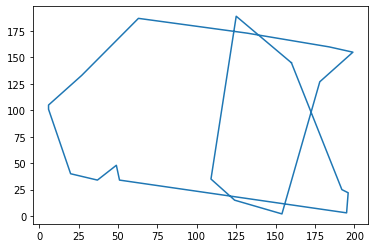

In [197]:
itr,plot.plot(x[p[maxit-1]],y[p[maxit-1]])

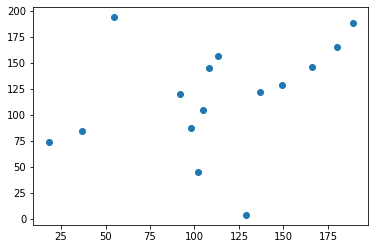

In [193]:
plot.scatter(x,y)